In [1]:
import pandas as pd
import numpy as np

import os
import sys
from tqdm import tqdm_notebook as tqdm
from glob import glob
import requests

import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import japanize_matplotlib
plt.rcParams["axes.grid"] = False
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## 人気 YOUTUBER をデータで解剖していく

In [2]:
# ref. https://note.nkmk.me/python-opencv-mosaic/
def mosaic(src, ratio=0.1):
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    return cv2.resize(small, src.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

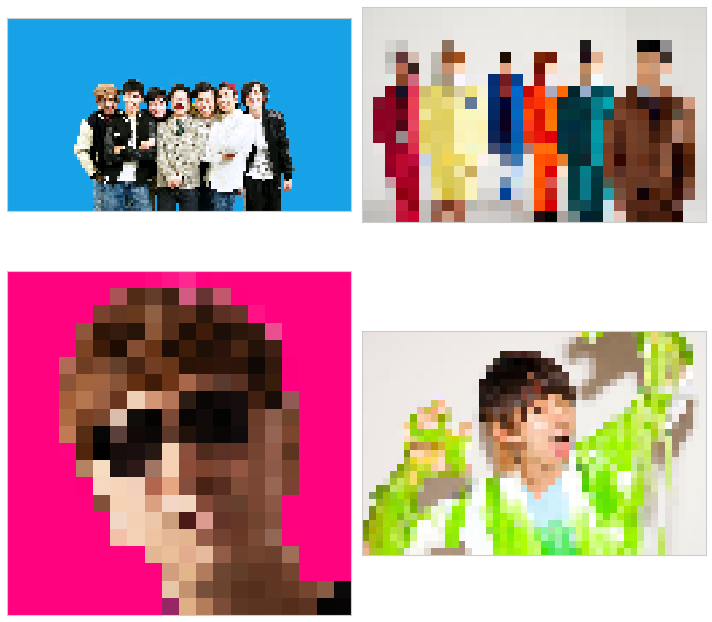

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for filename, ax in zip(glob('../figs/image*'), axs.flatten()):
    img = plt.imread(filename)
    # モザイク
    img = mosaic(img, 0.05)
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    ax.imshow(img)
plt.tight_layout()
plt.show()

## 人気 youtuber = 有名事務所に所属している方々
 - UUUM : https://www.uuum.jp/creator/
 - VAZ : https://vaz.tokyo/creator/
 - Kiii : https://kiii.co.jp/
 - oMo : https://omo.jp.net/creator.html
 - BREAKER : https://brkr.jp/all-creator/
 - E-DGE : https://e-dge.co.jp/creators-talent
 - GROVE : https://grove.tokyo/creator

In [2]:
from time import sleep
from abc import ABCMeta, abstractmethod

class channelIdCrawler(metaclass=ABCMeta):
    '''
    うまく抽象化できる気がするけど一旦場当たり的に関数作る

    '''
    def __init__(self, sleep_time=1):
        self.sleep_time = sleep_time

    def listChannelInfo(self, target_site_url):
        youtube_urls = self._scrapeYoutubeChannelURLs(target_site_url)
        channel_info = self._crawlAndScrapeChannelInfoFromYoutubeHTMLs(youtube_urls)
        return channel_info

    def listChannelInfoOnehop(self, target_site_url, hopkey):
        hopped_site_urls = self._scrapeHopeSiteURLs(target_site_url, hopkey)
        self.youtube_urls = []
        for hopped_site_url in tqdm(hopped_site_urls):
            self.youtube_urls.append(self._scrapeYoutubeChannelURLs(hopped_site_url)[0])
            sleep(self.sleep_time)
        channel_info = self._crawlAndScrapeChannelInfoFromYoutubeHTMLs(self.youtube_urls)
        return channel_info
    
    def _scrapeHopeSiteURLs(self, target_site_url, hopkey):
        '''
        " で url がうまく切られている前提

        '''
        res_site_urls = [line for line in filter(lambda x: hopkey in x, requests.get(target_site_url).text.split('"')) if line]
#        res_site_urls = [
#            list(
#                filter(lambda x: hopkey in x, line.split('"'))
#            )[0]
#            for line in filter(lambda x: hopkey in x, requests.get(target_site_url).text.split('\n')) if line]
        return res_site_urls

    def _crawlAndScrapeChannelInfoFromYoutubeHTMLs(self, youtube_urls):
        channel_info = []
        for youtube_url in tqdm(youtube_urls):
            youtube_html = requests.get(youtube_url).text
            channel_info.append(
                {'channel_url': youtube_url,
                'channelId': list(
                    filter(lambda x: 'channelId' in x, youtube_html.split('\n'))
                )[0].split('"')[3]}
            )
            sleep(self.sleep_time)
        return channel_info
    
    def _scrapeYoutubeChannelURLs(self, target_site_url):
        youtube_channel_urls = [
            list(
                filter(lambda x: 'www.youtube' in x, line.split('"'))
            )[0]
            for line in filter(lambda x: 'youtube.com/user' in x or 'youtube.com/channel' in x, requests.get(target_site_url).text.split('\n')) if line]
        return youtube_channel_urls

In [3]:
# UUUM
cic = channelIdCrawler()
uuum_channel_info = cic.listChannelInfo('https://www.uuum.jp/creator/')

In [5]:
# VAZ
cic = channelIdCrawler()
vaz_channel_info = cic.listChannelInfo('https://vaz.tokyo/creator/')

KeyboardInterrupt: 

In [11]:
# Kiii
kiii_channel_info = cic.listChannelInfo('https://kiii.co.jp/creators/')

KeyboardInterrupt: 

In [13]:
# oMo
omo_channel_info = cic.listChannelInfo('https://omo.jp.net/creator.html')

KeyboardInterrupt: 

In [15]:
# BREAKER
breaker_channel_info = cic.listChannelInfo('https://brkr.jp/all-creator/')

KeyboardInterrupt: 

In [18]:
# E-DGE
edge_channel_info = cic.listChannelInfoOnehop('https://e-dge.co.jp/creators-talent', hopkey='https://e-dge.co.jp/creator/')

KeyboardInterrupt: 

In [20]:
# glove のみ JS で面倒なのでてでソースを取ってくる
with open('../inputs/glove_creators_source.html', 'r') as fin:
    glove_html = fin.read()

page_urls = [line for line in filter(lambda x: 'https://grove.tokyo/creator/' in x and len(x) > len('https://grove.tokyo/creator/'), glove_html.split('"')) if line]
youtube_urls = []
for page_url in tqdm(page_urls):
    res = cic._scrapeYoutubeChannelURLs(page_url)
    if len(res) > 0:
        youtube_urls.append(res[0])
glove_channel_info = cic._crawlAndScrapeChannelInfoFromYoutubeHTMLs(youtube_urls)    

KeyboardInterrupt: 

In [25]:
uuum_channel_df = pd.DataFrame(uuum_channel_info)
uuum_channel_df['office'] = 'UUUM'

vaz_channel_df = pd.DataFrame()
vaz_channel_df['office'] = 'VAZ'

kiii_channel_df = pd.DataFrame(kiii_channel_info)
kiii_channel_df['office'] = 'Kiii'

omo_channel_df = pd.DataFrame(omo_channel_info)
omo_channel_df['office'] = 'oMo'

breaker_channel_df = pd.DataFrame(breaker_channel_info)
breaker_channel_df['office'] = 'BREAKER'

edge_channel_df = pd.DataFrame(edge_channel_info)
edge_channel_df['office'] = 'E-DGE'

glove_channel_df = pd.DataFrame(glove_channel_info)
glove_channel_df['office'] = 'GROVE'


channels_df = pd.concat(
[
    uuum_channel_df,
    vaz_channel_df,
    kiii_channel_df,
    omo_channel_df,
    breaker_channel_df,
    edge_channel_df,
    glove_channel_df,
], axis=0)

In [26]:
channels_df.head()

,channelId,channel_url,office
0,UCZf__ehlCEBPop-_sldpBUQ,https://www.youtube.com/user/HikakinTV,UUUM
1,UCgMPP6RRjktV7krOfyUewqw,https://www.youtube.com/user/0214mex,UUUM
2,UCg4nOl7_gtStrLwF0_xoV0A,https://www.youtube.com/user/SeikinTV,UUUM
3,UCFBjsYvwX7kWUjQoW7GcJ5A,https://www.youtube.com/user/eguri89,UUUM
4,UCzWygEC8zQKYpCp7nwX_M-A,https://www.youtube.com/user/PDSKabushikiGaisha,UUUM


In [27]:
channels_df.to_csv('../inputs/channels_df_temp.csv', index=False)

#### step2. リストから google の API を使ってよりリッチなデータを作る

In [18]:
from googleapiclient.discovery import build

API_KEY = os.environ['ASTT_YOUTUBE_API_KEY']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

youtube = build(API_SERVICE_NAME, API_VERSION, developerKey=API_KEY)

In [20]:
# API 叩く
channel_reses = []

for i, row in tqdm(list(channels_df.iterrows())):
    channel_res = youtube.channels().list(
        part = 'id,snippet,brandingSettings,contentDetails,invideoPromotion,statistics,topicDetails',
        id = row.channelId
    ).execute()
    channel_reses.append(channel_res)
    sleep(0.5)

In [23]:
import pickle
with open('../inputs/channel_api_res.pkl', 'wb') as fout:
    pickle.dump(channel_reses, fout)

In [24]:
channel_reses[0]

{'kind': 'youtube#channelListResponse',
 'etag': '"j6xRRd8dTPVVptg711_CSPADRfg/NzPsyklSPKNq_ALXLkG7Kvmo-J4"',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 1},
 'items': [{'kind': 'youtube#channel',
   'etag': '"j6xRRd8dTPVVptg711_CSPADRfg/44t55GpbrWvX57awnSaeKjpDOJQ"',
   'id': 'UCZf__ehlCEBPop-_sldpBUQ',
   'snippet': {'title': 'HikakinTV',
    'description': 'HikakinTVはヒカキンが日常の面白いものを紹介するチャンネルです。\n◆プロフィール◆\nYouTubeにてHIKAKIN、HikakinTV、HikakinGames、HikakinBlogと\n４つのチャンネルを運営し、動画の総アクセス数は100億回を突破、\nチャンネル登録者数は計1400万人以上、YouTubeタレント事務所uuum株式会社ファウンダー兼最高顧問。',
    'customUrl': 'hikakintv',
    'publishedAt': '2011-07-19T11:31:43.000Z',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6DTxipZbwT9geVv0N-XYLA=s88-c-k-c0xffffffff-no-rj-mo',
      'width': 88,
      'height': 88},
     'medium': {'url': 'https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6DTxipZbwT9geVv0N-XYLA=s240-c-k-c0xffffffff-no-rj-mo',
      'width': 240,
      'height': 240},
     'high': {'url

In [25]:
# 必要な情報を抜き出していく
hikakin_sample = channel_reses[0]
hikakin_sample.keys()

dict_keys(['kind', 'etag', 'pageInfo', 'items'])

In [50]:
import json

def parseChannelInfo(channel_detailed_info):
    channel_detailed_items = channel_detailed_info['items'][0]
    channelId = channel_detailed_items['id']
    title = channel_detailed_items['snippet']['title']
    publishedAt = channel_detailed_items['snippet']['publishedAt']
    thumbnail = channel_detailed_items['snippet']['thumbnails']['default']['url']
    viewCount = channel_detailed_items['statistics']['viewCount']
    commentCount =channel_detailed_items['statistics']['commentCount'] 
    subscriberCount = channel_detailed_items['statistics']['subscriberCount']
    videoCount = channel_detailed_items['statistics']['videoCount']
    if 'topicDetails' in channel_detailed_items and 'topicCategories' in channel_detailed_items['topicDetails']:
        topicCategories = json.dumps(channel_detailed_items['topicDetails']['topicCategories'])
    else:
        topicCategories = json.dumps([])
    return {
        'channelId': channelId,
        'title': title,
        'publishedAt': publishedAt,
        'thumbnail': thumbnail,
        'viewCount': viewCount,
        'commentCount': commentCount,
        'subscriberCount': subscriberCount,
        'videoCount': videoCount,
        'topicCategories': topicCategories
    }

In [51]:
#%debug
parsed_channel_info = []
for channel_sample in tqdm(channel_reses):
    parsed_channel_info.append(parseChannelInfo(channel_sample))
channel_detail_df = pd.DataFrame(parsed_channel_info)
display(channel_detail_df.shape, channel_detail_df.head())

(592, 9)

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount
0,UCZf__ehlCEBPop-_sldpBUQ,0,2011-07-19T11:31:43.000Z,7800000,https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6D...,HikakinTV,"[""https://en.wikipedia.org/wiki/Music"", ""https...",2653,6473641589
1,UCgMPP6RRjktV7krOfyUewqw,0,2012-08-31T04:19:50.000Z,8230000,https://yt3.ggpht.com/a/AGF-l7-iP9dkqSTTt-ctYj...,はじめしゃちょー（hajime）,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2031,6741091586
2,UCg4nOl7_gtStrLwF0_xoV0A,0,2012-01-29T16:53:15.000Z,3690000,https://yt3.ggpht.com/a/AGF-l78kk-uwyTLw5pHOGv...,SeikinTV,"[""https://en.wikipedia.org/wiki/Hobby"", ""https...",1675,3022233321
3,UCFBjsYvwX7kWUjQoW7GcJ5A,0,2010-04-10T02:11:44.000Z,1560000,https://yt3.ggpht.com/a/AGF-l7-WZyViCyzTPxau5Q...,瀬戸弘司 / Koji Seto,"[""https://en.wikipedia.org/wiki/Music"", ""https...",1925,811847389
4,UCzWygEC8zQKYpCp7nwX_M-A,0,2011-01-06T23:32:56.000Z,1580000,https://yt3.ggpht.com/a/AGF-l78AZbdoV23XpI-gy6...,PDSKabushikiGaisha,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2589,1164038893


In [52]:
channel_detail_df.iloc[0].thumbnail

'https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6DTxipZbwT9geVv0N-XYLA=s88-c-k-c0xffffffff-no-rj-mo'

In [54]:
channel_detail_df.to_csv('../inputs/channel_detail_df.tsv', index=False, sep='\t')

In [28]:
channel_detail_df = pd.read_csv('../inputs/channel_detail_df.tsv', sep='\t')

In [29]:
channel_detail_df.head()

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount
0,UCZf__ehlCEBPop-_sldpBUQ,0,2011-07-19T11:31:43.000Z,7800000,https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6D...,HikakinTV,"[""https://en.wikipedia.org/wiki/Music"", ""https...",2653,6473641589
1,UCgMPP6RRjktV7krOfyUewqw,0,2012-08-31T04:19:50.000Z,8230000,https://yt3.ggpht.com/a/AGF-l7-iP9dkqSTTt-ctYj...,はじめしゃちょー（hajime）,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2031,6741091586
2,UCg4nOl7_gtStrLwF0_xoV0A,0,2012-01-29T16:53:15.000Z,3690000,https://yt3.ggpht.com/a/AGF-l78kk-uwyTLw5pHOGv...,SeikinTV,"[""https://en.wikipedia.org/wiki/Hobby"", ""https...",1675,3022233321
3,UCFBjsYvwX7kWUjQoW7GcJ5A,0,2010-04-10T02:11:44.000Z,1560000,https://yt3.ggpht.com/a/AGF-l7-WZyViCyzTPxau5Q...,瀬戸弘司 / Koji Seto,"[""https://en.wikipedia.org/wiki/Music"", ""https...",1925,811847389
4,UCzWygEC8zQKYpCp7nwX_M-A,0,2011-01-06T23:32:56.000Z,1580000,https://yt3.ggpht.com/a/AGF-l78AZbdoV23XpI-gy6...,PDSKabushikiGaisha,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2589,1164038893


## 分析してみる

In [56]:
channel_detail_df = pd.read_csv('../inputs/channel_detail_df.tsv', sep='\t')
display(channel_detail_df.shape, channel_detail_df.head())

(592, 9)

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount
0,UCZf__ehlCEBPop-_sldpBUQ,0,2011-07-19T11:31:43.000Z,7800000,https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6D...,HikakinTV,"[""https://en.wikipedia.org/wiki/Music"", ""https...",2653,6473641589
1,UCgMPP6RRjktV7krOfyUewqw,0,2012-08-31T04:19:50.000Z,8230000,https://yt3.ggpht.com/a/AGF-l7-iP9dkqSTTt-ctYj...,はじめしゃちょー（hajime）,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2031,6741091586
2,UCg4nOl7_gtStrLwF0_xoV0A,0,2012-01-29T16:53:15.000Z,3690000,https://yt3.ggpht.com/a/AGF-l78kk-uwyTLw5pHOGv...,SeikinTV,"[""https://en.wikipedia.org/wiki/Hobby"", ""https...",1675,3022233321
3,UCFBjsYvwX7kWUjQoW7GcJ5A,0,2010-04-10T02:11:44.000Z,1560000,https://yt3.ggpht.com/a/AGF-l7-WZyViCyzTPxau5Q...,瀬戸弘司 / Koji Seto,"[""https://en.wikipedia.org/wiki/Music"", ""https...",1925,811847389
4,UCzWygEC8zQKYpCp7nwX_M-A,0,2011-01-06T23:32:56.000Z,1580000,https://yt3.ggpht.com/a/AGF-l78AZbdoV23XpI-gy6...,PDSKabushikiGaisha,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2589,1164038893


#### ① 人気 youtuber の登録者数ってどれくらい...?

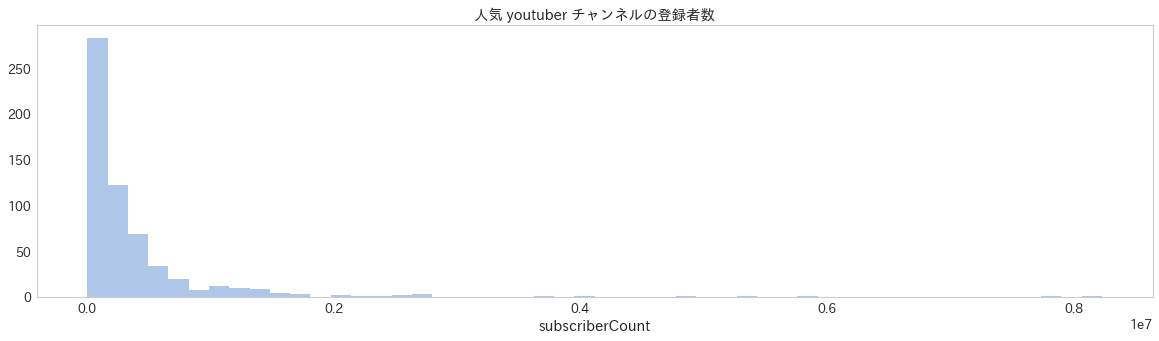

In [60]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

ax = axs
sns.distplot(channel_detail_df.subscriberCount, kde=False, ax=ax)
ax.set_title('人気 youtuber チャンネルの登録者数')
plt.show()

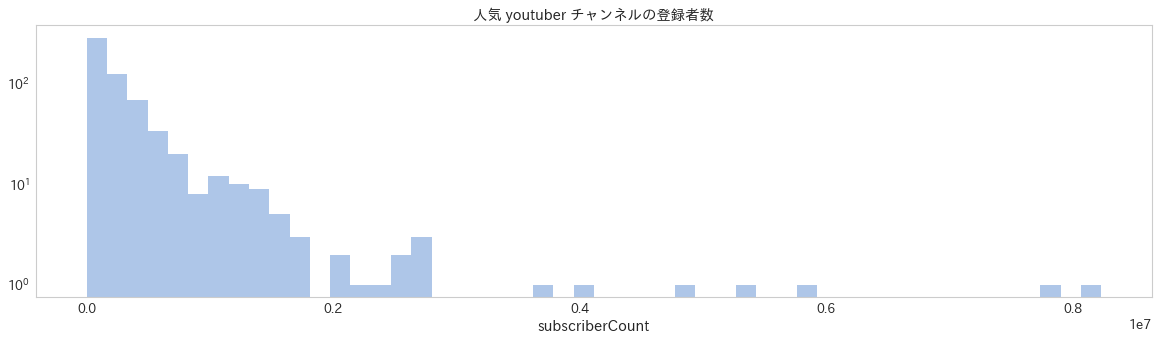

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

ax = axs
sns.distplot(channel_detail_df.subscriberCount, kde=False, ax=ax)
ax.set_title('人気 youtuber チャンネルの登録者数')

ax.set_yscale('log')
plt.show()

In [32]:
# 登録者数が多い人
channel_detail_df.sort_values('subscriberCount', ascending=False).head(10)

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount
1,UCgMPP6RRjktV7krOfyUewqw,0,2012-08-31T04:19:50.000Z,8230000,https://yt3.ggpht.com/a/AGF-l7-iP9dkqSTTt-ctYj...,はじめしゃちょー（hajime）,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",2031,6741091586
0,UCZf__ehlCEBPop-_sldpBUQ,0,2011-07-19T11:31:43.000Z,7800000,https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6D...,HikakinTV,"[""https://en.wikipedia.org/wiki/Music"", ""https...",2653,6473641589
12,UCibEhpu5HP45-w7Bq1ZIulw,0,2012-08-24T03:11:12.000Z,5850000,https://yt3.ggpht.com/a/AGF-l7_xqj8uBv-d_lY4-r...,Fischer's-フィッシャーズ-,"[""https://en.wikipedia.org/wiki/Entertainment""...",1959,8133248781
6,UCFTVNLC7ysej-sD5lkLqNGA,0,2014-05-21T11:01:01.000Z,5370000,https://yt3.ggpht.com/a/AGF-l7-kEfE13l8-MZVGby...,Yuka Kinoshita木下ゆうか,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",1792,1915508455
39,UCutJqz56653xV2wwSvut_hQ,0,2013-10-13T03:25:55.000Z,4780000,https://yt3.ggpht.com/a/AGF-l79ikuSwQTvQdFN78x...,東海オンエア,"[""https://en.wikipedia.org/wiki/Entertainment""...",1441,4858582578
13,UCpOjLndjOqMoffA-fr8cbKA,0,2014-10-06T16:18:37.000Z,4110000,https://yt3.ggpht.com/a/AGF-l7-aOeiF2a5P-9hX1Y...,水溜りボンド,"[""https://en.wikipedia.org/wiki/Entertainment""...",1828,2862391656
2,UCg4nOl7_gtStrLwF0_xoV0A,0,2012-01-29T16:53:15.000Z,3690000,https://yt3.ggpht.com/a/AGF-l78kk-uwyTLw5pHOGv...,SeikinTV,"[""https://en.wikipedia.org/wiki/Hobby"", ""https...",1675,3022233321
26,UCzKa8fRPoCbKh8O9yW2JK2g,0,2013-03-18T11:03:07.000Z,2700000,https://yt3.ggpht.com/a/AGF-l79rjYu0H2T83Ue0pX...,桐崎栄二.きりざきえいじ,"[""https://en.wikipedia.org/wiki/Entertainment""...",499,1253668514
207,UC8_wmm5DX9mb4jrLiw8ZYzw,0,2016-07-13T05:55:04.000Z,2700000,https://yt3.ggpht.com/a/AGF-l79Wv6rRNoFDQv4J19...,スカイピース,"[""https://en.wikipedia.org/wiki/Food"", ""https:...",1292,1655784539
88,UCzXjPL7zo0bxhOYDxLJ9YEg,0,2013-07-22T05:32:42.000Z,2660000,https://yt3.ggpht.com/a/AGF-l79k9chzoUCm_cbBxK...,ポッキー,"[""https://en.wikipedia.org/wiki/Role-playing_v...",2528,2437803998


In [40]:
# 登録者数が少ない人
channel_detail_df.sort_values('subscriberCount', ascending=True).head(10)

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount,channel_url,office
51,UCt3u1FCTR1Sc3Eumycrzvwg,0,2011-12-19T12:06:40.000Z,0,https://yt3.ggpht.com/a/AGF-l7-6K6y1YhqmwFouhe...,しほりみチャンネルShiho & Rimi Channel,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",3012,151094446,https://www.youtube.com/user/ShihoRimi,UUUM
295,UCPH3UFJx-Mj21bOFBeWvRjQ,0,2016-12-31T18:02:50.000Z,0,https://yt3.ggpht.com/a/AGF-l7_ZzMAPuM8nGMcvh2...,たーたんねる,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",121,129577693,https://www.youtube.com/channel/UCPH3UFJx-Mj21...,kiii
1052,UCfPdNaCpykXNmpn0dC6HJzA,0,2019-07-17T02:39:13.000Z,44,https://yt3.ggpht.com/a/AGF-l7-I1_jxWBhfU4hNef...,本当はブスチャンネル,"[""https://en.wikipedia.org/wiki/Physical_fitne...",5,1296,https://www.youtube.com/channel/UCfPdNaCpykXNm...,GROVE
1061,UCjFop9UOA0ygI0jOGzr2bQg,0,2015-10-14T08:12:41.000Z,46,https://yt3.ggpht.com/a/AGF-l7_WMKI3aiZQrc7381...,Kamiのちゃんねる,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",3,2493,https://www.youtube.com/channel/UCjFop9UOA0ygI...,GROVE
264,UCqNqP-HpPq5IMwASReda23w,0,2015-11-15T01:41:49.000Z,209,https://yt3.ggpht.com/a/AGF-l7-jiXRQdsAXTrQYvh...,Nah Vampire,[],0,0,https://www.youtube.com/channel/UCqNqP-HpPq5IM...,VAZ
512,UCp-d_pgiKWZ6r5kHDPFjxDg,0,2018-12-15T08:49:09.000Z,295,https://yt3.ggpht.com/a/AGF-l78zMLgppwzUgffB9L...,あゆみチャンネル,"[""https://en.wikipedia.org/wiki/Entertainment""...",59,41020,https://www.youtube.com/channel/UCp-d_pgiKWZ6r...,oMo
268,UC7_RRFtnRr6JvKNA_DM3ffw,0,2014-12-14T11:21:15.000Z,334,https://yt3.ggpht.com/a/AGF-l7-TqwCo8LUVjY22nm...,おんなしゃちょー奮闘記,"[""https://en.wikipedia.org/wiki/Music"", ""https...",9,3103,https://www.youtube.com/channel/UC7_RRFtnRr6Jv...,VAZ
1060,UCQyO2GYnJo-ifENTNIbESRA,0,2015-11-17T10:45:11.000Z,363,https://yt3.ggpht.com/a/AGF-l783uevp8jGiMCX6oV...,インドでぃんch,"[""https://en.wikipedia.org/wiki/Entertainment""...",4,10887,https://www.youtube.com/channel/UCQyO2GYnJo-if...,GROVE
261,UCYklWac3hsDSCicrR3-F3rA,0,2017-06-19T09:21:46.000Z,385,https://yt3.ggpht.com/a/AGF-l784EFN_z87voMl87i...,ちあきチャンネル,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",5,16344,https://www.youtube.com/channel/UCYklWac3hsDSC...,VAZ
308,UCjJWPf3CYSzc_l__V1pjkRA,0,2013-12-26T09:22:23.000Z,481,https://yt3.ggpht.com/a/AGF-l79DZ1gxZfbS-GlIIr...,OmO Channel,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",17,7151,https://www.youtube.com/user/OmOjp/channels,oMo


#### 人気のジャンル

In [57]:
import json
json.loads(channel_detail_df.topicCategories.iloc[0])[5].split('/')[-1]

'Food'

In [65]:
# 全カテゴリを集計
nested_cats = channel_detail_df.topicCategories.apply(lambda x: [cat_url.split('/')[-1] for cat_url in json.loads(x)]).tolist()
nested_cats

[['Music', 'Hobby', 'Entertainment', 'Lifestyle_(sociology)', 'Pet', 'Food'],
 ['Lifestyle_(sociology)', 'Entertainment'],
 ['Hobby', 'Food', 'Lifestyle_(sociology)', 'Music', 'Entertainment'],
 ['Music', 'Entertainment', 'Lifestyle_(sociology)', 'Technology'],
 ['Lifestyle_(sociology)', 'Film', 'Food', 'Entertainment'],
 ['Food', 'Entertainment', 'Lifestyle_(sociology)'],
 ['Lifestyle_(sociology)', 'Food'],
 ['Technology', 'Food', 'Lifestyle_(sociology)'],
 ['Pet', 'Lifestyle_(sociology)', 'Food'],
 ['Lifestyle_(sociology)', 'Technology', 'Hobby'],
 ['Hobby', 'Technology', 'Lifestyle_(sociology)', 'Video_game_culture'],
 ['Food', 'Entertainment', 'Film', 'Lifestyle_(sociology)'],
 ['Entertainment', 'Lifestyle_(sociology)'],
 ['Entertainment', 'Lifestyle_(sociology)', 'Food'],
 ['Lifestyle_(sociology)', 'Entertainment', 'Food'],
 ['Food', 'Lifestyle_(sociology)', 'Physical_fitness'],
 ['Pet', 'Food', 'Hobby', 'Lifestyle_(sociology)'],
 ['Video_game_culture',
  'Sports_game',
  'Lifesty

In [68]:
import itertools
flatten_cats = list(itertools.chain.from_iterable(nested_cats))
flatten_cats

['Music',
 'Hobby',
 'Entertainment',
 'Lifestyle_(sociology)',
 'Pet',
 'Food',
 'Lifestyle_(sociology)',
 'Entertainment',
 'Hobby',
 'Food',
 'Lifestyle_(sociology)',
 'Music',
 'Entertainment',
 'Music',
 'Entertainment',
 'Lifestyle_(sociology)',
 'Technology',
 'Lifestyle_(sociology)',
 'Film',
 'Food',
 'Entertainment',
 'Food',
 'Entertainment',
 'Lifestyle_(sociology)',
 'Lifestyle_(sociology)',
 'Food',
 'Technology',
 'Food',
 'Lifestyle_(sociology)',
 'Pet',
 'Lifestyle_(sociology)',
 'Food',
 'Lifestyle_(sociology)',
 'Technology',
 'Hobby',
 'Hobby',
 'Technology',
 'Lifestyle_(sociology)',
 'Video_game_culture',
 'Food',
 'Entertainment',
 'Film',
 'Lifestyle_(sociology)',
 'Entertainment',
 'Lifestyle_(sociology)',
 'Entertainment',
 'Lifestyle_(sociology)',
 'Food',
 'Lifestyle_(sociology)',
 'Entertainment',
 'Food',
 'Food',
 'Lifestyle_(sociology)',
 'Physical_fitness',
 'Pet',
 'Food',
 'Hobby',
 'Lifestyle_(sociology)',
 'Video_game_culture',
 'Sports_game',
 'Lif

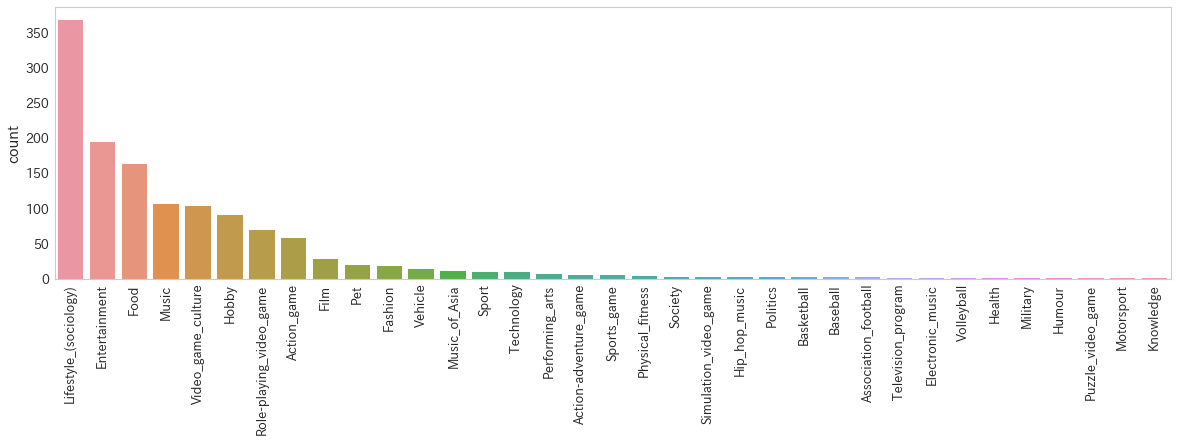

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
ax = axs
sns.countplot(flatten_cats, ax=ax, order=pd.Series(flatten_cats).value_counts().index)
ax.tick_params(axis='x', rotation=90)

In [79]:
channel_detail_df[channel_detail_df.topicCategories.str.contains('Music')]

,channelId,commentCount,publishedAt,subscriberCount,thumbnail,title,topicCategories,videoCount,viewCount,channel_url,office
0,UCZf__ehlCEBPop-_sldpBUQ,0,2011-07-19T11:31:43.000Z,7800000,https://yt3.ggpht.com/a/AGF-l7-kxzTs5JiGxQW-6D...,HikakinTV,"[""https://en.wikipedia.org/wiki/Music"", ""https...",2653,6473641589,https://www.youtube.com/user/HikakinTV,UUUM
2,UCg4nOl7_gtStrLwF0_xoV0A,0,2012-01-29T16:53:15.000Z,3690000,https://yt3.ggpht.com/a/AGF-l78kk-uwyTLw5pHOGv...,SeikinTV,"[""https://en.wikipedia.org/wiki/Hobby"", ""https...",1675,3022233321,https://www.youtube.com/user/SeikinTV,UUUM
3,UCFBjsYvwX7kWUjQoW7GcJ5A,0,2010-04-10T02:11:44.000Z,1560000,https://yt3.ggpht.com/a/AGF-l7-WZyViCyzTPxau5Q...,瀬戸弘司 / Koji Seto,"[""https://en.wikipedia.org/wiki/Music"", ""https...",1925,811847389,https://www.youtube.com/user/eguri89,UUUM
21,UCFs-PaPhAlUQ2qUG8gHf_zA,0,2013-12-11T10:35:36.000Z,115000,https://yt3.ggpht.com/a/AGF-l7_o2vYWiHhxA_O-18...,オネガイシマス海賊団!!!,"[""https://en.wikipedia.org/wiki/Film"", ""https:...",1620,64707662,https://www.youtube.com/user/TAKASHIsTV,UUUM
22,UCJ98lzh2QJGp37QgWPUcwrQ,0,2014-04-06T13:00:53.000Z,2060000,https://yt3.ggpht.com/a/AGF-l79HL2L722xRx7Wt4Y...,HIMAWARIちゃんねる,"[""https://en.wikipedia.org/wiki/Lifestyle_(soc...",1321,3063667024,https://www.youtube.com/user/himawari7859,UUUM
27,UCoG2iDwh5Vw61kZx0kWL0WA,0,2010-11-06T00:10:30.000Z,1130000,https://yt3.ggpht.com/a/AGF-l78d03EcJ77X2aClmp...,北の打ち師達,"[""https://en.wikipedia.org/wiki/Music"", ""https...",877,419547622,https://www.youtube.com/channel/UCoG2iDwh5Vw61...,UUUM
28,UCMsuwHzQPFMDtHaoR7_HDxg,0,2016-06-01T20:20:51.000Z,1150000,https://yt3.ggpht.com/a/AGF-l789apEwDXEVp7xBa3...,ゆきりぬ,"[""https://en.wikipedia.org/wiki/Entertainment""...",922,341815487,https://www.youtube.com/channel/UCMsuwHzQPFMDt...,UUUM
33,UCR1_4Tla5MlZlDK8WM5vklA,0,2015-01-12T04:31:55.000Z,365000,https://yt3.ggpht.com/a/AGF-l79Kr3TZddE717g8zd...,brother4 channel,"[""https://en.wikipedia.org/wiki/Music"", ""https...",719,295035360,https://www.youtube.com/channel/UCR1_4Tla5MlZl...,UUUM
38,UCdtFmWwPlKiCOEND_95fwiA,0,2015-10-13T13:19:47.000Z,91100,https://yt3.ggpht.com/a/AGF-l789fXI-2BeV6tsUE_...,美音（みおと/Mioto）,"[""https://en.wikipedia.org/wiki/Entertainment""...",469,18222667,https://www.youtube.com/channel/UCdtFmWwPlKiCO...,UUUM
43,UCPyNsNSTUtywkekbDdCA_8Q,0,2014-11-27T13:34:05.000Z,1470000,https://yt3.ggpht.com/a/AGF-l79S4y5etSiNWNjeZ0...,はなお,"[""https://en.wikipedia.org/wiki/Entertainment""...",513,537446629,https://www.youtube.com/channel/UCPyNsNSTUtywk...,UUUM


#### 登録してからの日数と登録者数の関係を見てみる

In [86]:
channel_detail_df['yd'] = channel_detail_df['publishedAt'].apply(lambda x: x[:7])
channel_detail_df['y'] = channel_detail_df['publishedAt'].apply(lambda x: x[:4])

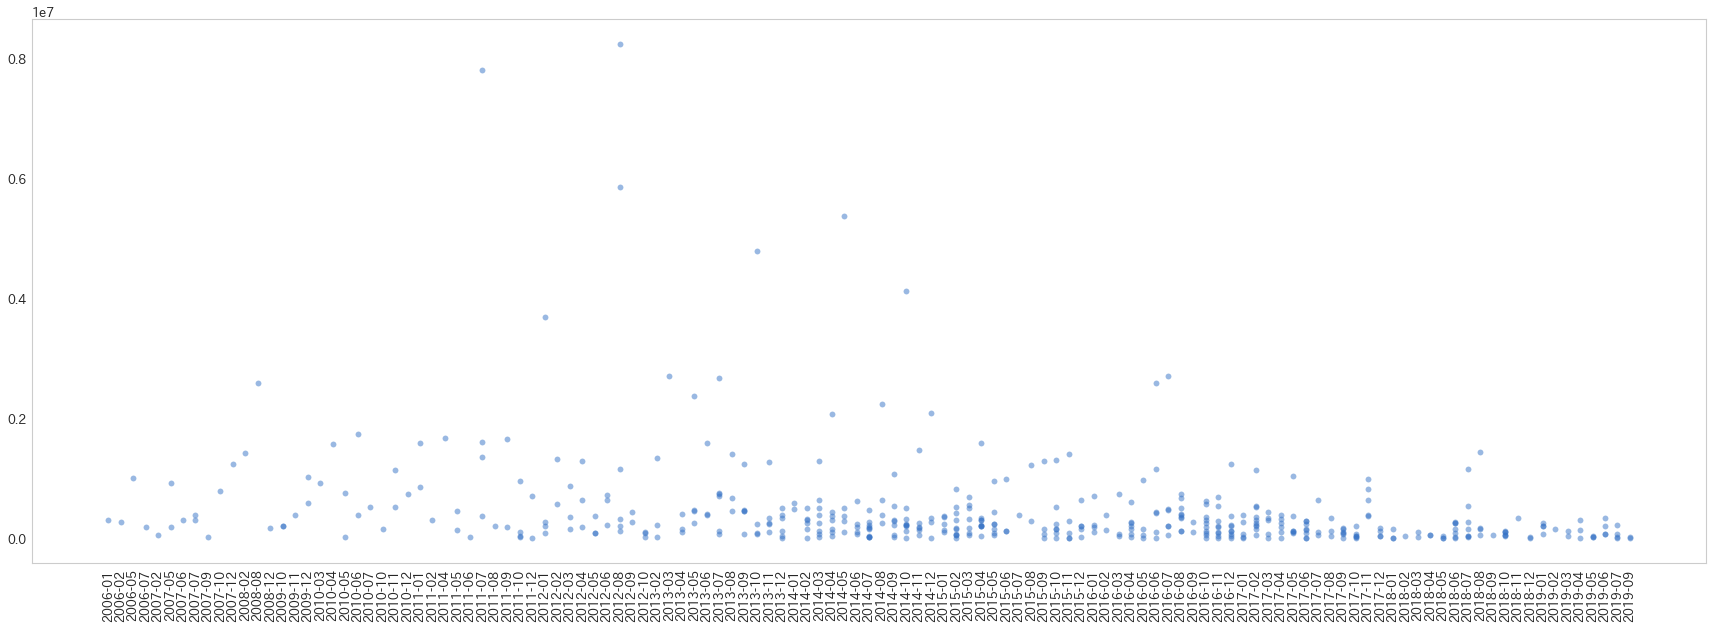

In [89]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
ax = axs
ax.scatter(channel_detail_df.sort_values('yd').yd, channel_detail_df.sort_values('yd').subscriberCount, alpha=0.5)
ax.tick_params(axis='x', rotation=90)

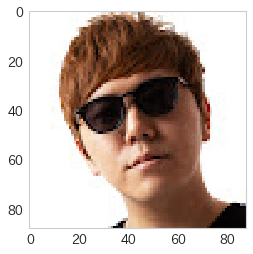

In [69]:
import io
from PIL import Image
fig = Image.open(io.BytesIO(requests.get(channel_detail_df.iloc[0].thumbnail).content))
plt.imshow(fig)